In [ ]:
import re
import datetime
import bz2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Dropout, Flatten, GlobalMaxPooling1D,MaxPool1D,MaxPooling1D

In [ ]:
def decompress_bz2 (input_file_path,output_file_path) :

    with open(input_file_path,'rb') as input_file,open(output_file_path,'wb') as output_file :
        decompressor = bz2.BZ2Decompressor()

        for i in iter(lambda : input_file.read(4096),b'') :
            output_file.write(decompressor.decompress(i))

    print(f'Decompression complete. Output file saved at: {output_file_path}')

In [ ]:
def structured_data(file):
    text = open(file).read().splitlines()
    data = [line.split(' ', 1) for line in text]

    for i in data:
        i[0] = int(i[0].replace('__label__', ''))


    df = pd.DataFrame(data, columns=['label', 'text'])

    return df

In [ ]:
train_df = structured_data('/content/drive/MyDrive/Datasets/AmazonReview/train.ft.txt')

In [ ]:
train_df = train_df.sample(frac=0.05, random_state=42)

In [ ]:
train_df.shape

(180000, 2)

In [ ]:
train_df.head()


,label,text
2079998,1,Expensive Junk: This product consists of a pie...
1443106,1,"Toast too dark: Even on the lowest setting, th..."
3463669,2,Excellent imagery...dumbed down story: I enjoy...
2914699,1,Are we pretending everyone is married?: The au...
1603231,1,Not worth your time: Might as well just use a ...


In [ ]:
train_df['label'].unique()

array([1, 2])

In [ ]:
df = train_df

In [ ]:
df.columns

Index(['label', 'text'], dtype='object')

In [ ]:
df['label'] = df['label'].map({1: 0, 2: 1})

In [ ]:
df['label'].iloc[3]

0

In [ ]:
df['label'].nunique()

2

In [ ]:
df.isna().sum()

label    0
text     0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180000 entries, 2079998 to 295818
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   180000 non-null  int64 
 1   text    180000 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.1+ MB


In [ ]:
df.describe

<bound method NDFrame.describe of          label                                               text
2079998      0  Expensive Junk: This product consists of a pie...
1443106      0  Toast too dark: Even on the lowest setting, th...
3463669      1  Excellent imagery...dumbed down story: I enjoy...
2914699      0  Are we pretending everyone is married?: The au...
1603231      0  Not worth your time: Might as well just use a ...
...        ...                                                ...
803182       0  regrettable!: I'ts a great pity that Jamiroqua...
316943       1  150 LED light bulb: I have 10 of these bulbs s...
2849293      1  Great chew toy!!: This toy is the only chew to...
2613128      0  Dent on your baby's head: I got one as a gift....
295818       0  Would NOT Recommend Arctic Twister: In this da...

[180000 rows x 2 columns]>

In [ ]:
df['label'].value_counts()

1    90098
0    89902
Name: label, dtype: int64

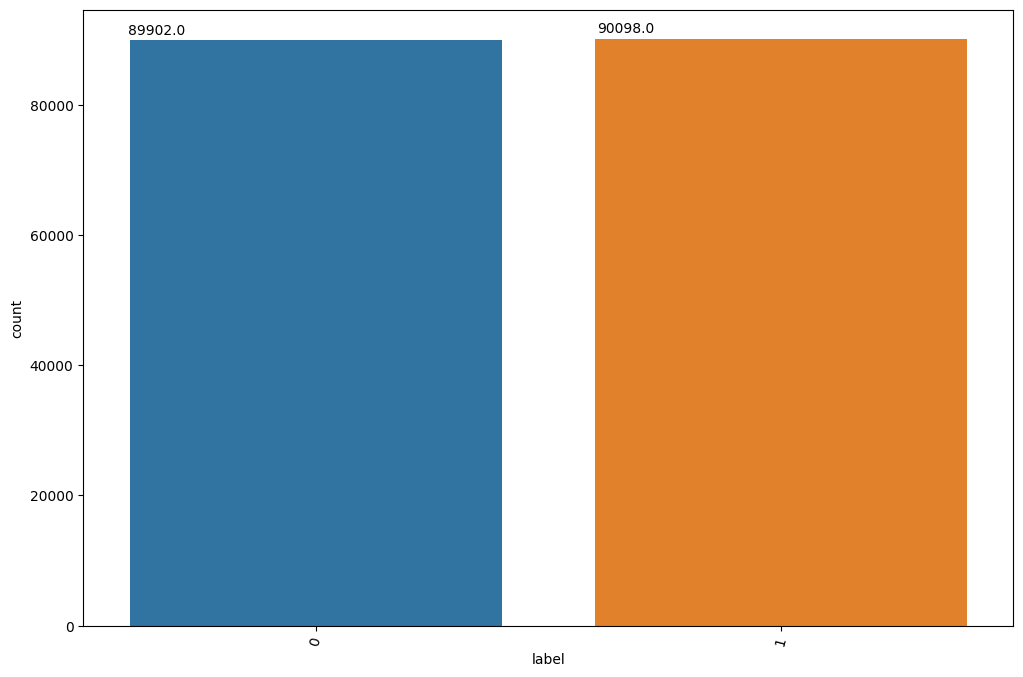

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data=df,x='label')
plt.xticks(rotation=75)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.show()

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')    #used as wordcloud
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df['text'] = df['text'].apply(lambda x:x.lower())
for i in range(len(df)):
    lw=[]
    for j in df['text'].iloc[i].split():
        if len(j)>=3:
            lw.append(j)
    df['text'].iloc[i]=" ".join(lw)

In [ ]:
ps = list(";$?.:-()[]/\'_!,")
df['text'] = df['text']

for p in ps:
    df['text'] = df['text'].str.replace(p, '')

In [ ]:
df['text'] = df['text'].str.replace(r'\d+', '')
df['text'] = df['text'].str.replace("    ", " ")
df['text'] = df['text'].str.replace('"', '')
df['text'] = df['text'].apply(lambda x: x.replace('\t', ' '))
df['text'] = df['text'].str.replace("'s", "")
df['text'] = df['text'].apply(lambda x: x.replace('\n', ' '))

In [ ]:
df['text'] = df['text'].apply(lambda x: x.lower())
df['text']

2079998    expensive junk this product consists piece thi...
1443106    toast too dark even the lowest setting the toa...
3463669    excellent imagerydumbed down story enjoyed thi...
2914699    are pretending everyone married the authors pr...
1603231    not worth your time might well just use knife ...
                                 ...                        
803182     regrettable its great pity that jamiroquai hav...
316943      led light bulb have these bulbs far use them ...
2849293    great chew toy this toy the only chew toy dog ...
2613128    dent your babys head got one gift its bit anno...
295818     would not recommend arctic twister this day te...
Name: text, Length: 180000, dtype: object

In [ ]:
stop = set(STOPWORDS)

def remove_stopwords(text):
    words = text.split()  # Split the sentence into words
    filtered_words = [word for word in words if word.lower() not in stop]
    return ' '.join(filtered_words)

df['text'] = df['text'].apply(remove_stopwords)

In [ ]:
df['text'].iloc[0]

'expensive junk product consists piece thin flexible insulating material adhesive backed velcro white electrical tapeproblems instructions three pictures little information velcro crumpled received stronger adhesive tried disengage velcro pieces came paint ceiling white electrical tape horrible cheap narrow fell less hour price ripoffi building easier use cheaper attractive higher rvalue surprised amazon even lists junk'

In [ ]:
wl = WordNetLemmatizer()


In [ ]:
nr = len(df)
lis = []
for r in range(0, nr):
    ll = []
    t = df['text'].iloc[r]
    tw = str(t).split(" ")
    for w in tw:
        ll.append(wl.lemmatize(w, pos="v"))
    lt = " ".join(ll)
    lis.append(lt)

In [ ]:
lis

['expensive junk product consist piece thin flexible insulate material adhesive back velcro white electrical tapeproblems instructions three picture little information velcro crumple receive stronger adhesive try disengage velcro piece come paint ceiling white electrical tape horrible cheap narrow fell less hour price ripoffi build easier use cheaper attractive higher rvalue surprise amazon even list junk',
 'toast dark even lowest set toast dark like light stay light unplug avoid waste electricity quality expect cuisinart',
 'excellent imagerydumbed story enjoy disc video stun agree others story dumbed take childish approach actually seem little one side proenvironmental nevertheless enjoyable say amazon wmv disc better story better sharper image interest things look',
 'pretend everyone marry author pretend parent neither die divorce insist marriage rock upon behavior wellbeing child build send clear message nontraditional households book people play game life way everyone suffer bad

In [ ]:
df['text'] = lis

In [ ]:
df['text'].iloc[0]

'expensive junk product consist piece thin flexible insulate material adhesive back velcro white electrical tapeproblems instructions three picture little information velcro crumple receive stronger adhesive try disengage velcro piece come paint ceiling white electrical tape horrible cheap narrow fell less hour price ripoffi build easier use cheaper attractive higher rvalue surprise amazon even list junk'

In [ ]:
X = df.text.values
y = df.label.values

In [ ]:
print(X)

['expensive junk product consist piece thin flexible insulate material adhesive back velcro white electrical tapeproblems instructions three picture little information velcro crumple receive stronger adhesive try disengage velcro piece come paint ceiling white electrical tape horrible cheap narrow fell less hour price ripoffi build easier use cheaper attractive higher rvalue surprise amazon even list junk'
 'toast dark even lowest set toast dark like light stay light unplug avoid waste electricity quality expect cuisinart'
 'excellent imagerydumbed story enjoy disc video stun agree others story dumbed take childish approach actually seem little one side proenvironmental nevertheless enjoyable say amazon wmv disc better story better sharper image interest things look'
 ...
 'great chew toy toy chew toy dog destroy week arent even teeth mark really worth money guarantee manufacturer cant lose dog kobe love way bounce make kong material bone shape keep occupy much longer complaint little 

In [ ]:
print(y)

[0 0 1 ... 1 0 0]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

max_len =  1000
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len, padding='post')

In [ ]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

253865

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
embed_dim = 300
max_length = 1000

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,GRU,SpatialDropout1D,SimpleRNN,BatchNormalization

In [ ]:
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(64,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(16)),
    Dense(1, activation='sigmoid')
])

In [ ]:
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         32494720  
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 64)          41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                1

In [ ]:
# Compile the model
bilstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
bilstm_history = bilstm_model.fit(X_train, y_train , validation_data=(X_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
2250/2250 [==============================] - 429s 186ms/step - loss: 0.3447 - accuracy: 0.8483 - val_loss: 0.3172 - val_accuracy: 0.8629
Epoch 2/5
2250/2250 [==============================] - 406s 180ms/step - loss: 0.3065 - accuracy: 0.8681 - val_loss: 0.3090 - val_accuracy: 0.8673
Epoch 3/5
2250/2250 [==============================] - 407s 181ms/step - loss: 0.2908 - accuracy: 0.8752 - val_loss: 0.2998 - val_accuracy: 0.8715
Epoch 4/5
2250/2250 [==============================] - 407s 181ms/step - loss: 0.2781 - accuracy: 0.8819 - val_loss: 0.2966 - val_accuracy: 0.8718
Epoch 5/5
2250/2250 [==============================] - 406s 180ms/step - loss: 0.2655 - accuracy: 0.8876 - val_loss: 0.3024 - val_accuracy: 0.8721


In [ ]:

# Get predictions on test data
y_pred = (bilstm_model.predict(X_test) > 0.5).astype("int32")



1125/1125 [==============================] - 78s 67ms/step


In [ ]:
# Accuracy
bilstm_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {bilstm_accuracy}')

# F1 Score
bilstm_f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {bilstm_f1}')

# Confusion Matrix
bilstm_conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{bilstm_conf_matrix}')

# Classification Report
bilstm_class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{bilstm_class_report}')


Accuracy: 0.8721388888888889
F1 Score: 0.8723056010208893
Confusion Matrix:
[[15675  2399]
 [ 2204 15722]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     18074
           1       0.87      0.88      0.87     17926

    accuracy                           0.87     36000
   macro avg       0.87      0.87      0.87     36000
weighted avg       0.87      0.87      0.87     36000



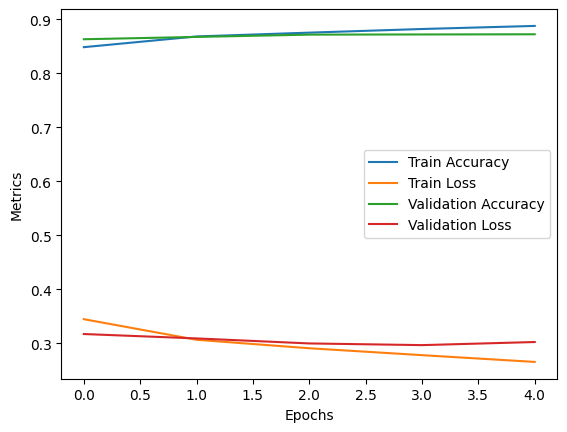

In [ ]:
plt.plot(bilstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(bilstm_history.history['loss'], label='Train Loss')
plt.plot(bilstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(bilstm_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [ ]:
# Save the model
# bilstm_model.save('/content/drive/MyDrive/Datasets/AmazonReview/bilstm_model.h5')

In [ ]:
model = Sequential([
    Embedding(vocab_size, embed_dim, input_length=max_length),
    Conv1D(64, 4, activation='relu', padding='same'),
    MaxPooling1D(2),
    Dropout(0.1),
    Conv1D(64, 4, activation='relu', padding='same'),
    MaxPooling1D(2),
    Dropout(0.1),
    Conv1D(64, 4, activation='relu', padding='same'),
    MaxPooling1D(2),
    Flatten(),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 300)         76159500  
                                                                 
 conv1d (Conv1D)             (None, 1000, 64)          76864     
                                                                 
 max_pooling1d (MaxPooling1  (None, 500, 64)           0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 500, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 250, 64)           0         
 g1D)                                                 

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

Epoch 1/10
2250/2250 [==============================] - 120s 52ms/step - loss: 0.3795 - accuracy: 0.8198 - val_loss: 0.3227 - val_accuracy: 0.8605
Epoch 2/10
2250/2250 [==============================] - 96s 42ms/step - loss: 0.3062 - accuracy: 0.8678 - val_loss: 0.3073 - val_accuracy: 0.8668
Epoch 3/10
2250/2250 [==============================] - 95s 42ms/step - loss: 0.2863 - accuracy: 0.8789 - val_loss: 0.3007 - val_accuracy: 0.8707
Epoch 4/10
2250/2250 [==============================] - 94s 42ms/step - loss: 0.2593 - accuracy: 0.8935 - val_loss: 0.3043 - val_accuracy: 0.8701
Epoch 5/10
2250/2250 [==============================] - 93s 41ms/step - loss: 0.2283 - accuracy: 0.9084 - val_loss: 0.3075 - val_accuracy: 0.8704
Epoch 6/10
2250/2250 [==============================] - 95s 42ms/step - loss: 0.1968 - accuracy: 0.9232 - val_loss: 0.3248 - val_accuracy: 0.8630
Epoch 7/10
2250/2250 [==============================] - 94s 42ms/step - loss: 0.1703 - accuracy: 0.9345 - val_loss: 0.3478 

In [ ]:
# Get predictions on test data
cnn_y_pred = (model.predict(X_test) > 0.5).astype("int32")

1125/1125 [==============================] - 5s 4ms/step


In [ ]:
# Accuracy
cnn_accuracy = accuracy_score(y_test, cnn_y_pred)
print(f'Accuracy: {cnn_accuracy}')

# F1 Score
cnn_f1 = f1_score(y_test, cnn_y_pred)
print(f'F1 Score: {cnn_f1}')

# Confusion Matrix
cnn_conf_matrix = confusion_matrix(y_test, cnn_y_pred)
print(f'Confusion Matrix:\n{cnn_conf_matrix}')

# Classification Report
cnn_class_report = classification_report(y_test, cnn_y_pred)
print(f'Classification Report:\n{cnn_class_report}')


Accuracy: 0.8572777777777778
F1 Score: 0.8602741216142716
Confusion Matrix:
[[15045  3029]
 [ 2109 15817]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     18074
           1       0.84      0.88      0.86     17926

    accuracy                           0.86     36000
   macro avg       0.86      0.86      0.86     36000
weighted avg       0.86      0.86      0.86     36000



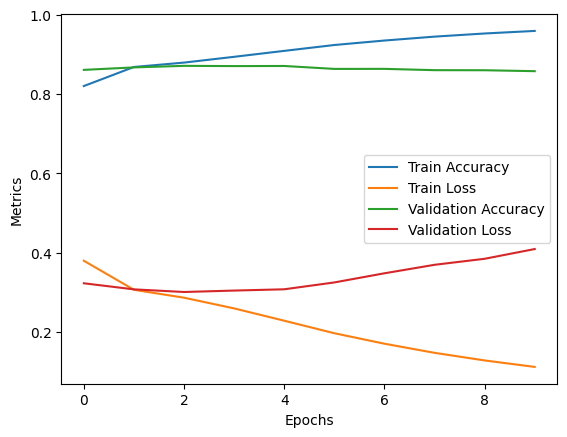

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [ ]:
# Save the model
# model.save('/content/drive/MyDrive/Datasets/AmazonReview/cnn_model.h5')

In [ ]:
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(GRU(64,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(GRU(32, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(GRU(16)),
    Dense(1, activation='sigmoid')
])

In [ ]:
gru_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
gru_history = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
2250/2250 [==============================] - 416s 181ms/step - loss: 0.3401 - accuracy: 0.8507 - val_loss: 0.3157 - val_accuracy: 0.8629
Epoch 2/5
2250/2250 [==============================] - 400s 178ms/step - loss: 0.3022 - accuracy: 0.8707 - val_loss: 0.3001 - val_accuracy: 0.8700
Epoch 3/5
2250/2250 [==============================] - 401s 178ms/step - loss: 0.2854 - accuracy: 0.8774 - val_loss: 0.2964 - val_accuracy: 0.8742
Epoch 4/5
2250/2250 [==============================] - 400s 178ms/step - loss: 0.2729 - accuracy: 0.8837 - val_loss: 0.2977 - val_accuracy: 0.8736
Epoch 5/5
2250/2250 [==============================] - 400s 178ms/step - loss: 0.2603 - accuracy: 0.8899 - val_loss: 0.2937 - val_accuracy: 0.8741


In [ ]:
gru_y_pred = (gru_model.predict(X_test) > 0.5).astype("int32")

1125/1125 [==============================] - 76s 66ms/step


In [ ]:
# Accuracy
gru_accuracy = accuracy_score(y_test, gru_y_pred)
print(f'Accuracy: {gru_accuracy}')

# F1 Score
gru_f1 = f1_score(y_test, gru_y_pred)
print(f'F1 Score: {gru_f1}')

# Confusion Matrix
gru_conf_matrix = confusion_matrix(y_test, gru_y_pred)
print(f'Confusion Matrix:\n{gru_conf_matrix}')

# Classification Report
gru_class_report = classification_report(y_test, gru_y_pred)
print(f'Classification Report:\n{gru_class_report}')

Accuracy: 0.8740833333333333
F1 Score: 0.8752648523706007
Confusion Matrix:
[[15563  2511]
 [ 2022 15904]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     18074
           1       0.86      0.89      0.88     17926

    accuracy                           0.87     36000
   macro avg       0.87      0.87      0.87     36000
weighted avg       0.87      0.87      0.87     36000



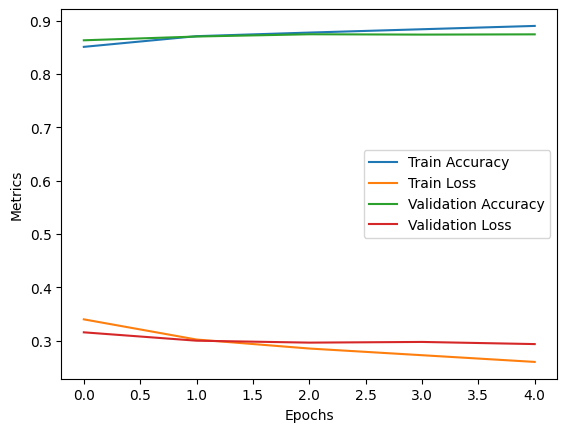

In [ ]:
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [ ]:
# Save the model
# model.save('/content/drive/MyDrive/Datasets/AmazonReview/gru_model.h5')

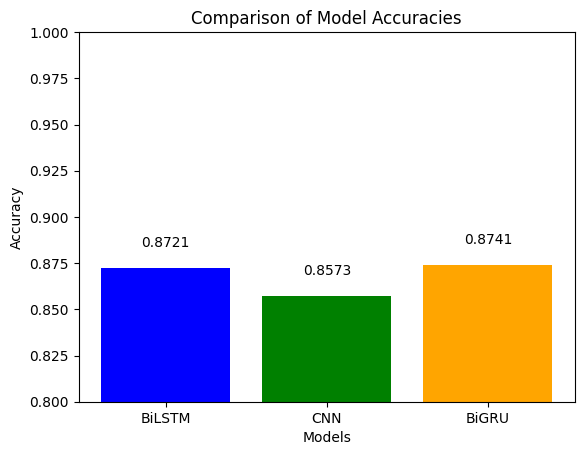

In [ ]:
models = ['BiLSTM', 'CNN', 'BiGRU']
accuracies = [bilstm_accuracy, cnn_accuracy, gru_accuracy]

plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0.8, 1.0)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')


for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()
plt.show()

In [ ]:
cnngru_model =Sequential([
   Embedding(vocab_size, embed_dim, input_length=max_length),
    Conv1D(64, 4, activation='relu', padding='same',kernel_regularizer=l2(0.03)),
    BatchNormalization(),
    Dropout(0.2),
    GRU(128, activation='relu', return_sequences=True),
    Flatten(),
    Dense(1, activation='sigmoid')
])


In [ ]:
cnngru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
rnn_history = cnngru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)


Epoch 1/5
2250/2250 [==============================] - 2887s 1s/step - loss: 0.4032 - accuracy: 0.8441 - val_loss: 0.4972 - val_accuracy: 0.7778
Epoch 2/5
2061/2250 [==========================>...] - ETA: 3:48 - loss: 0.3428 - accuracy: 0.8603

In [ ]:
# Get predictions on test data
cnngru_y_pred = (cnngru_model.predict(X_test) > 0.5).astype("int32")

In [ ]:
# Accuracy
cnngru_accuracy = accuracy_score(y_test, cnngru_y_pred)
print(f'Accuracy: {cnngru_accuracy}')

# F1 Score
cnngru_f1 = f1_score(y_test, cnngru_y_pred)
print(f'F1 Score: {cnngru_f1}')

# Confusion Matrix
cnngru_conf_matrix = confusion_matrix(y_test, cnngru_y_pred)
print(f'Confusion Matrix:\n{cnngru_conf_matrix}')

# Classification Report
cnngru_class_report = classification_report(y_test, cnngru_y_pred)
print(f'Classification Report:\n{cnngru_class_report}')


In [ ]:
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [ ]:
# Save the model
# model.save('/content/drive/MyDrive/Datasets/AmazonReview/cnngru_model.h5')

In [ ]:
models = ['BiLSTM', 'CNN', 'BiGRU','CNN-GRU']
accuracies = [bilstm_accuracy, cnn_accuracy, gru_accuracy, cnngru_accuracy]

plt.bar(models, accuracies, color=['blue', 'green', 'orange','red'])
plt.ylim(0.8, 1.0)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')


for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()
plt.show()